In [1]:
!pip install uproot3
!pip install uproot_methods
!pip install mplhep
!pip install awkward

     |████████████████████████████████| 122kB 5.8MB/s 
     |████████████████████████████████| 92kB 7.8MB/s 
     |████████████████████████████████| 92kB 2.9MB/s 
     |████████████████████████████████| 5.4MB 5.4MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import uproot3 as ROOT
import uproot_methods as upm
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import font_manager
import mplhep as hep


In [5]:
! ls /content/drive/MyDrive/Event_Sample/

BKG_Drellyan.root  DM_10GeV_scalar_d.root


In [6]:
## 리딩 투젯 마스크
def jet_ht_cut(data,nb):
  globals()['jet_mask{}'.format(nb)] = np.zeros(data.shape)
  for i in range(0,len(data)):
    if data.counts[i] >= 2:
     globals()['jet_mask{}'.format(nb)][i] = data[i,0] + data[i,1]

## 리딩 투렙 마스크
def nb_lep(data1,data2,nb):
  globals()['lep_mask{}'.format(nb)] = np.zeros(data1.shape)
  for i in range(0,len(data1)):
    if (data1.counts[i] + data2.counts[i] >= 2):
      if (data1.counts[i] == 0):
        globals()['lep_mask{}'.format(nb)][i] = data2[i,0] + data2[i,1]
      elif (data2.counts[i] == 0):
        globals()['lep_mask{}'.format(nb)][i] = data1[i,0] + data1[i,1]
      else:
        globals()['lep_mask{}'.format(nb)][i] = data1[i,0] + data2[i,0]


In [7]:
dat1 = ROOT.open("/content/drive/MyDrive/Event_Sample/BKG_Drellyan.root")["Delphes"]
dat2 = ROOT.open("/content/drive/MyDrive/Event_Sample/DM_10GeV_scalar_d.root")["Delphes"]

In [8]:
MET1_arr, Elec1_PT_arr, Muon1_PT_arr, Jet1_PT_arr = dat1.arrays(['MissingET.MET', 'Electron.PT', 'Muon.PT', 'Jet.PT'],outputtype=tuple)
MET2_arr, Elec2_PT_arr, Muon2_PT_arr, Jet2_PT_arr = dat2.arrays(['MissingET.MET', 'Electron.PT', 'Muon.PT', 'Jet.PT'],outputtype=tuple)


In [9]:
## 마스크 조건(제트)
jet_ht_cut(Jet1_PT_arr,1)
jet_ht_cut(Jet2_PT_arr,2)
jet_mask1 = jet_mask1 > 50
jet_mask2 = jet_mask2 > 50

In [10]:
## 마스크 조건(렙톤)
nb_lep(Elec1_PT_arr, Muon1_PT_arr,1)
nb_lep(Elec2_PT_arr, Muon2_PT_arr,2)
lep_mask1 = lep_mask1 > 120
lep_mask2 = lep_mask2 > 120

In [11]:
## 코로나가 발생하였습니다. 마스크를 써주세요
MET_dy = MET1_arr[jet_mask1 & lep_mask1].flatten()
MET_sg = MET2_arr[jet_mask2 & lep_mask2].flatten()

In [12]:
## 노말라이즈
x_dy = 1013.0
x_sg = 0.0002683
lumi = 150000
tot_evt = 10000.0

wght_dy = np.ones(MET_dy.shape) * x_dy * lumi/ tot_evt
wght_sg = np.ones(MET_sg.shape) * x_sg * lumi/ tot_evt

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


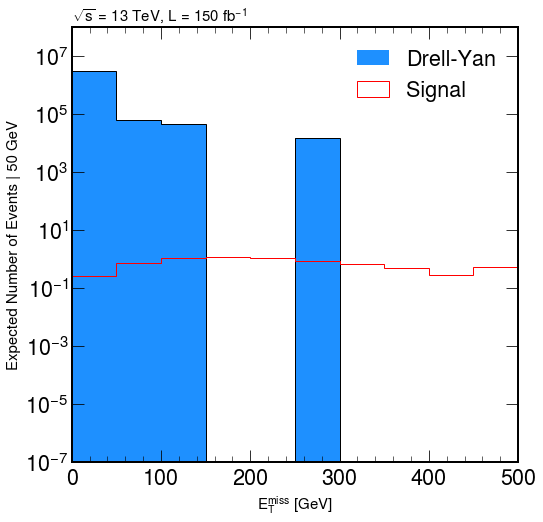

In [13]:
## 그림 그리기
plt.style.use(hep.style.ROOT)
plt.rcParams["figure.figsize"] = (8,8)
plt.xlim(0,500)
plt.ylim(0.0000001, 100000000)
plt.yscale('log')
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

## 채워진 히스토그램
plt.hist(np.clip(MET_dy,0,500,out=MET_dy), range=(0,500),weights=wght_dy, bins=10, label='Drell-Yan',color='dodgerblue')

## 겉선따기
plt.hist(np.clip(MET_dy,0,500,out=MET_dy), range=(0,500),weights=wght_dy, bins=10,color='black', histtype='step')

## 속이빈 강정
plt.hist(np.clip(MET_sg,0,500,out=MET_sg), range=(0,500),weights=wght_sg, bins=10, label='Signal',color='red',histtype='step')

## 제목 만들기
plt.title("$\sqrt{s}$ = 13 TeV, L = 150 fb$^{-1}$", loc='left',fontsize=15)
plt.xlabel("$E$$^{miss}_{T}$ [GeV]", fontsize=15)
plt.ylabel("Expected Number of Events | 50 GeV", fontsize=15)
plt.legend()
plt.minorticks_on()